# B-Spline 

开一个演示讲义. scipy 自带 BSpline 模块.

In [1]:
import numpy as np
from scipy.interpolate import BSpline as bspline
from matplotlib import pyplot as plt

我们先利用内置的 B 样条模块, 对样条基函数建立一个直观感受:

In [2]:
def draw_basis(N, n, i):
    t = np.linspace(-10, 10, num = N + n + 1, endpoint=True)
    f = np.zeros((N, N))
    for j in range(N):
        f[j, j] = 1
    spl = bspline(t, f[i,:], n)
    x = np.linspace(t[n], t[-(n+1)], num=400, endpoint=True)
    o = np.ones(len(x))
    plt.plot(x, spl(x), x, o, '--')

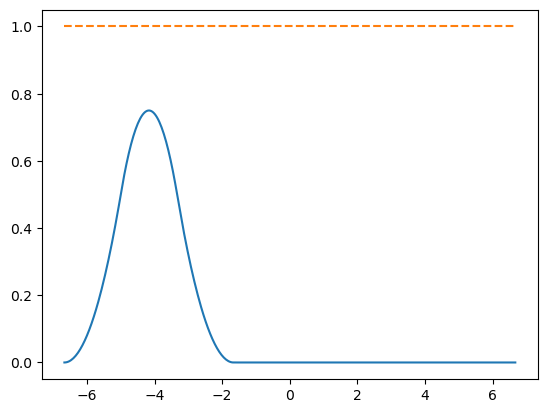

In [3]:
draw_basis(10, 2, 2)

画出全部 $n$ 阶 B 样条基函数:

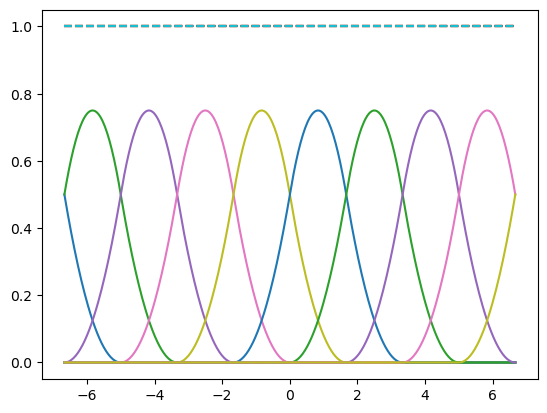

In [4]:
n = 2
N = 10
for i in range(N):
    draw_basis(N, n, i)

公式浓缩了信息. 比如这里利用一阶截断指数函数描述了 $(t - x)_+$ 这样的分段线性函数:

In [5]:
def tpow(x, t):
    t = np.ones(len(x)) * t
    return(t - x > 0) * (t - x)

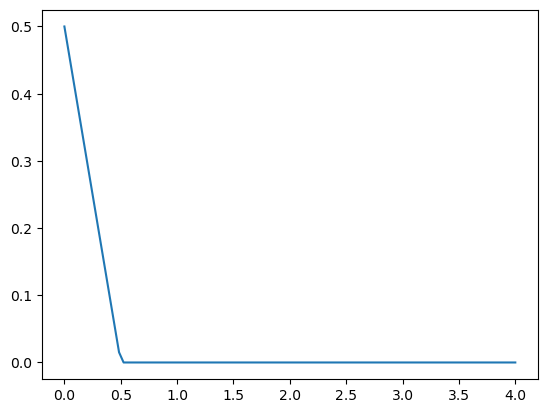

In [6]:
x = np.linspace(0, 4, 100)
t = 0.5
plt.plot(x, tpow(x, t))

分段线性函数在相邻节点的图像, 也就是讲义例子 3.31 下方图的第一列:

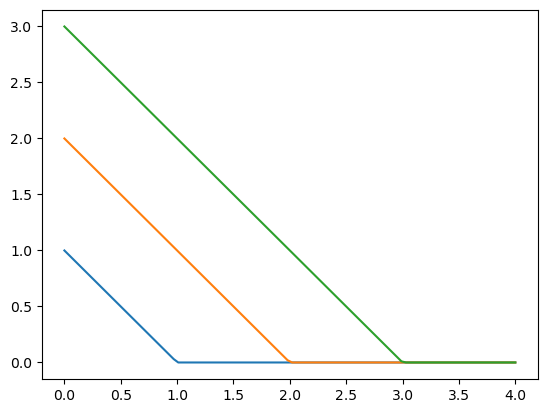

In [7]:
plt.plot(x, tpow(x, 1.0), x, tpow(x, 2.0), x, tpow(x, 3.0))

再利用分段线性函数在相邻节点的差商 $\frac{(t_{i + 1} - x)_+ - (t_i - x)_+}{t_{i + 1} - t_i}$, 将导数的跳跃限制在目标区间. 即讲义例 3.31 下图的第二列:

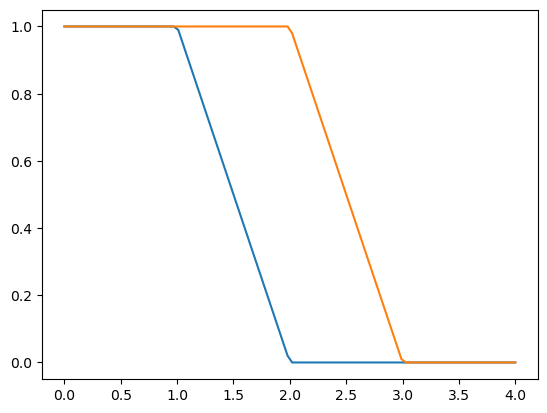

In [8]:
plt.plot(x, tpow(x, 2.0) - tpow(x, 1.0), x, tpow(x, 3.0) - tpow(x, 2.0))

上面两条曲线再做差, 就得到 B 样条一次局部基函数: 

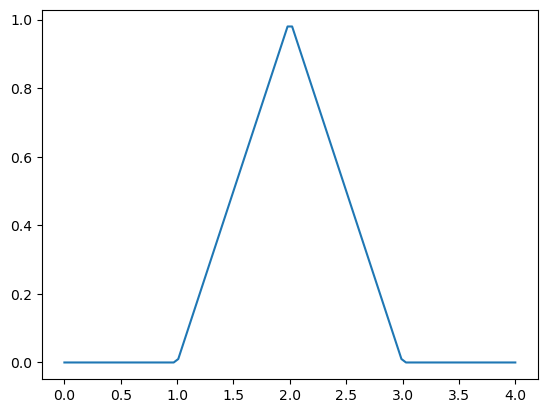

In [9]:
plt.plot(x, tpow(x, 3.0) - tpow(x, 2.0) - (tpow(x, 2.0) - tpow(x, 1.0)))

现在我们严格按照讲义定义做一些测试, 先构建 B-样条基函数 $B_{i, \mathbb{Z}}^n$:

In [10]:
def Bspline(n, i, x):
    if (n == 0):
        return (x > i - 1) * (x <= i) * 1.0
    else:
        return (x - i + 1) / n * Bspline(n - 1, i, x) + (i + n - x) / n * Bspline(n - 1, i + 1, x)

随便画画做做测试:

In [11]:
x = np.linspace(0, 10, 100)

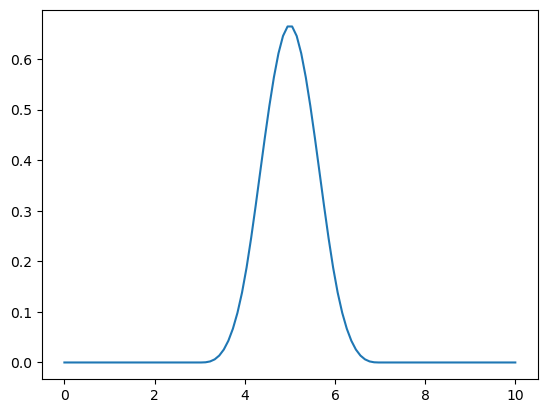

In [12]:
plt.plot(x, Bspline(3, 4, x))

现在构建一个目标函数进行拟合: 
$$
f(x) = \sin(\frac{\pi}{2}x), 
$$
因为是函数拟合, 所以我们可以直接手工构建函数和导函数:

In [13]:
def obj_func(x):
    return np.sin(0.5 * np.pi * x)
def obj_dfunc(x):
    return 0.5 * np.pi * np.cos(0.5 * np.pi * x)

这里夹带点私货, 把我们接下去需要的三对角方程组求解器准备好, 也就是追赶法, 国外叫 Thomas 算法: 

In [15]:
def Thomas(La, Mb, Uc, Rd):
    # https://www.jianshu.com/p/ef2027568912
    n=len(Mb)
    c=np.zeros(n-1)
    d=np.zeros(n)
    c[0]=Uc[0]/Mb[0]
    for i in range(1,n-1):
        c[i]=Uc[i]/(Mb[i]-c[i-1]*La[i-1])
    d[0]=Uc[0]/Mb[0]
    for i in range(1,n):
        d[i]=(Rd[i]-(d[i-1]*La[i-1]))/(Mb[i]-c[i-1]*La[i-1])
    ls=list(range(n-1))[::-1]
    x=np.zeros(n)
    x[n-1]=d[n-1]
    for i in ls:
        x[i]=d[i]-c[i]*x[i+1]
    return(x)

自己重构的原因是我们可以直接针对数组的形式进行计算, 反正这个算法很容易实现, 网上到处都是, 这里注释中标注了参考网站. 现在我们对一下符号, N, a, b 意义和讲义一致. Md 是三对角矩阵 M 的对角元, Mb 和 Ma 分别表示下和上副对角线. M 阵是对称的, 但这个并没有给追赶法带来额外的好处. 

In [16]:
N = 15
Md = np.ones(N) * 4.0
Md[0] = Md[N - 1] = 2.0
Mb = Ma = np.ones(N - 1)
b = np.zeros(N)
for i in range(1, N - 1):
    b[i] = obj_func(i + 1) * 6.0
b[0] = obj_func(1) * 3.0 + obj_dfunc(1)
b[N - 1] = obj_func(N) * 3.0 - obj_dfunc(N)
a = np.zeros(N + 2)

解线性方程组:

In [17]:
a[1:N+1] = Thomas(Ma, Md, Ma, b)

处理边界:

In [18]:
a[0] = a[2] - obj_dfunc(1) * 2.0
a[N+1] = a[N-1] + obj_dfunc(N) * 2.0

根据计算出来的系数 a 拼装样条函数 s, 也即讲义中的 (3.71):

In [19]:
x = np.linspace(0, 16, 400)
s = np.zeros(400)
for i in range(-1,N+1):
    s += a[i + 1] * Bspline(3,i,x)

绘制模拟结果, 注意虚线是原函数, 实线是样条拟合结果:

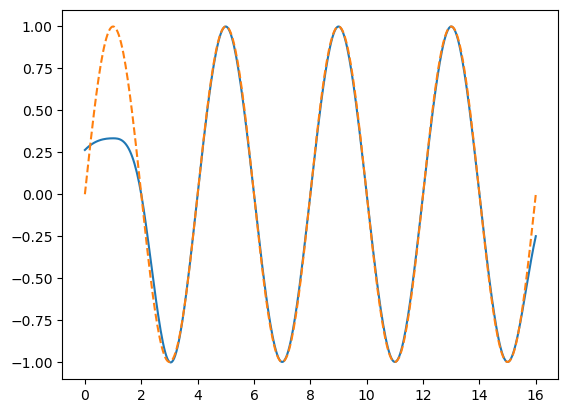

In [20]:
plt.plot(x, s, x, obj_func(x), '--')

大家注意到, 似乎好的拟合区间局限在 $[3, 15]$? 画一下误差曲线能验证:

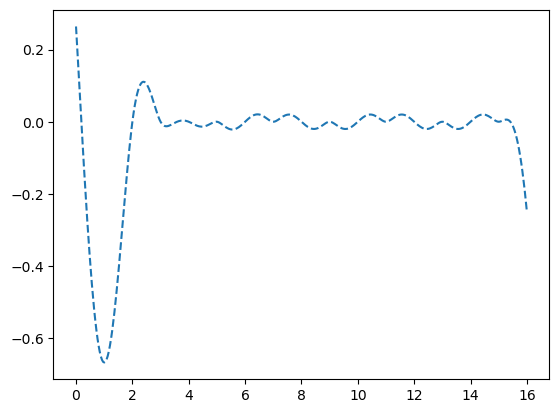

In [21]:
x = np.linspace(0, 16, 400)
s = np.zeros(400)
for i in range(-1,N+1):
    s += a[i + 1] * Bspline(3,i,x)
plt.plot(x, s - obj_func(x), '--')

In [ ]:
x = np.linspace(2, 16, 400)
s = np.zeros(400)
for i in range(-1,N+1):
    s += a[i + 1] * Bspline(3,i,x)
plt.plot(x, s - obj_func(x), '--')

In [ ]:
x = np.linspace(3, 15, 400)
s = np.zeros(400)
for i in range(-1,N+1):
    s += a[i + 1] * Bspline(3,i,x)
plt.plot(x, s - obj_func(x), '--')

注意我这里每一次的 $B_{i, \mathbb{Z}}^n$ 都重算了, 实际工作中, 可以算好存在那里. 一个问题是, 为什么我们的型值点是分布在 $[1, 15]$, 但是准确的拟合是 $[3, 15]$? 是有 bug 么?

**本程序仅供演示和理解算法使用, 严禁用于实际计算工作.**